# Data-driven approach to identify Pan-Glial specific markers

This notebook provides a guide for our aproach in glial specific genes as described in our manuscript and employs the same approach as described in our Sheat/Socket feature ranking analysis.

The following packages need to be installed before running this notebook:

1. `scanpy`: https://scanpy.readthedocs.io/en/stable/installation.html
2. `sklearn`: https://scikit-learn.org/stable/install.html
3. `tqdm`: https://github.com/tqdm/tqdm#installation
4. `plotly`: https://plotly.com/python/getting-started/

Refer to the our github page for environment setup: https://github.com/settylab/worm-glia-atlas

# Parameters

`Anndata` objects are the primary input for this notebook. The data (count matrix) within `anndata` object should be normalized, logtransformed. Additionally, imputed gene expression is used for the feature ranking/identification step. The following parameters that need to be specified are denoted below:
1. `CLASS_LABELS`   : is the `anndata.obs` field that contains the ground truth labels for which to identify markers for.
2. `CLUSTER_LABELS` : is the `anndata.obs` field that contains the leiden clusters that either belong to either two of the classes in the ground truth labels.
3. `USE_GENES`      : is the `anndata.var` field that determines whether a gene is to be included in the analysis, this is a column of boolean values and by default is set to the `highly_variable` genes.
3. `USE_LAYER`      : is the `anndata.layer` field that contains the imputed count matrix data.
5. `SAVE_PATH`      : a folder/path to save trained models and anndata outputs.
6. `EXCLUDE_GROUPS` : are clusters to exclude from the analysis.
7. `IGNORE_FEATURES`: are the genes to be excluded during the ranking portion of the anlaysis.


The code cell below shows the input of this analysis.

In [1]:
# anndata.obs columns labels used in analysis
CLASS_LABELS = 'class_labels'
CLUSTER_LABELS = 'cluster_comp'

# anndata.var columns label
USE_GENES = 'highly_variable'

# anndata.layers keys
USE_LAYER = 'magic_imputed_postBC'

# save path
SAVE_PATH = '2023-09-18-PanGlia_Analysis'

# Imports

In [2]:
# important imports
import anndata as AnnData
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# distance metrics related imports
import scipy
from scipy.stats import spearmanr
from scipy.stats import zscore
from scipy.stats import pearsonr
from sklearn.metrics import pairwise_distances

# for t-test to determine if 
from scipy.stats import ttest_ind


# utils
import tqdm
import os 
import glob
import sys

# multiprocessing/parallelizing tasks
from joblib import Parallel, delayed, dump, load

# imports needed for marker selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_precision_recall_curve, plot_confusion_matrix, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics.pairwise import paired_distances
from sklearn.feature_selection import RFE

# copy models
from copy import deepcopy

# Plot Presets

In [3]:
%matplotlib inline

# set matplotlib style -- ggplot
style.use('ggplot')

# config for matplotlib
matplotlib.rcParams['figure.figsize'] = [5,5]
matplotlib.rcParams['figure.dpi'] = 2000
matplotlib.rcParams['image.cmap'] = 'Spectral_r'

# config for scanpy
sc.settings.verbosity = 0
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')


# no bounding boxes or axis:
matplotlib.rcParams['axes.spines.bottom'] = "off"
matplotlib.rcParams['axes.spines.top'] = "off"
matplotlib.rcParams['axes.spines.left'] = "off"
matplotlib.rcParams['axes.spines.right'] = "off"

scanpy==1.9.1 anndata==0.8.0 umap==0.5.1 numpy==1.21.0 scipy==1.7.0 pandas==1.3.0 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


In [4]:
# functions for feature ranking 
sys.path.append('../utils/')
from feature_ranking import *

# The AnnData Object

The anndata below contains all the cells from single nuclear RNA sequencing with each cluster labels. We've identified glial clusters and non-glial clusters and use these as ground truth labels for this analyses.

In [5]:
# load in the data
adata = sc.read("data/WholeData.h5ad")
adata

AnnData object with n_obs × n_vars = 31410 × 12376
    obs: 'leiden_postBC', 'leiden_preBC', 'sex', 'Compartments_postBC', 'Celltype', 'cluster_sex_label_postBC', 'Compartments_preBC', 'samples', 'sex_specificity_postBC', 'sex_specificity_preBC', 'Cluster_Celltype', 'class_labels', 'cluster_comp_sexes', 'cluster_comp'
    var: 'previous_highly_variable', 'highly_variable'
    uns: 'Celltype_colors', 'Compartments_colors', 'Compartments_postBC_colors', 'Compartments_preBC_colors', 'DMEigenValues_postBC', 'DMEigenValues_preBC', 'class_labels_colors', 'cluster_sex_label_colors', 'dendrogram_Cluster_Celltype', 'gene_validations', 'leiden_postBC_colors', 'leiden_preBC_colors', 'samples_colors', 'sex_colors', 'sex_frac_postBC', 'sex_frac_preBC', 'sex_specificity_colors', 'sex_specificity_postBC_colors', 'sex_specificity_preBC_colors'
    obsm: 'DM_EigenVectors_postBC', 'DM_EigenVectors_preBC', 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_noBC'
    varm: 'PCs', 'cluster_means', 'pairwise_clust

The `anndata` object contains several meta data information as shown by the output from the previous cell. We visualize `CLASS_LABELS` & `CLUSTER_LABELS` below which are the primary we `anndata.obs` field we focus on in this tutorial

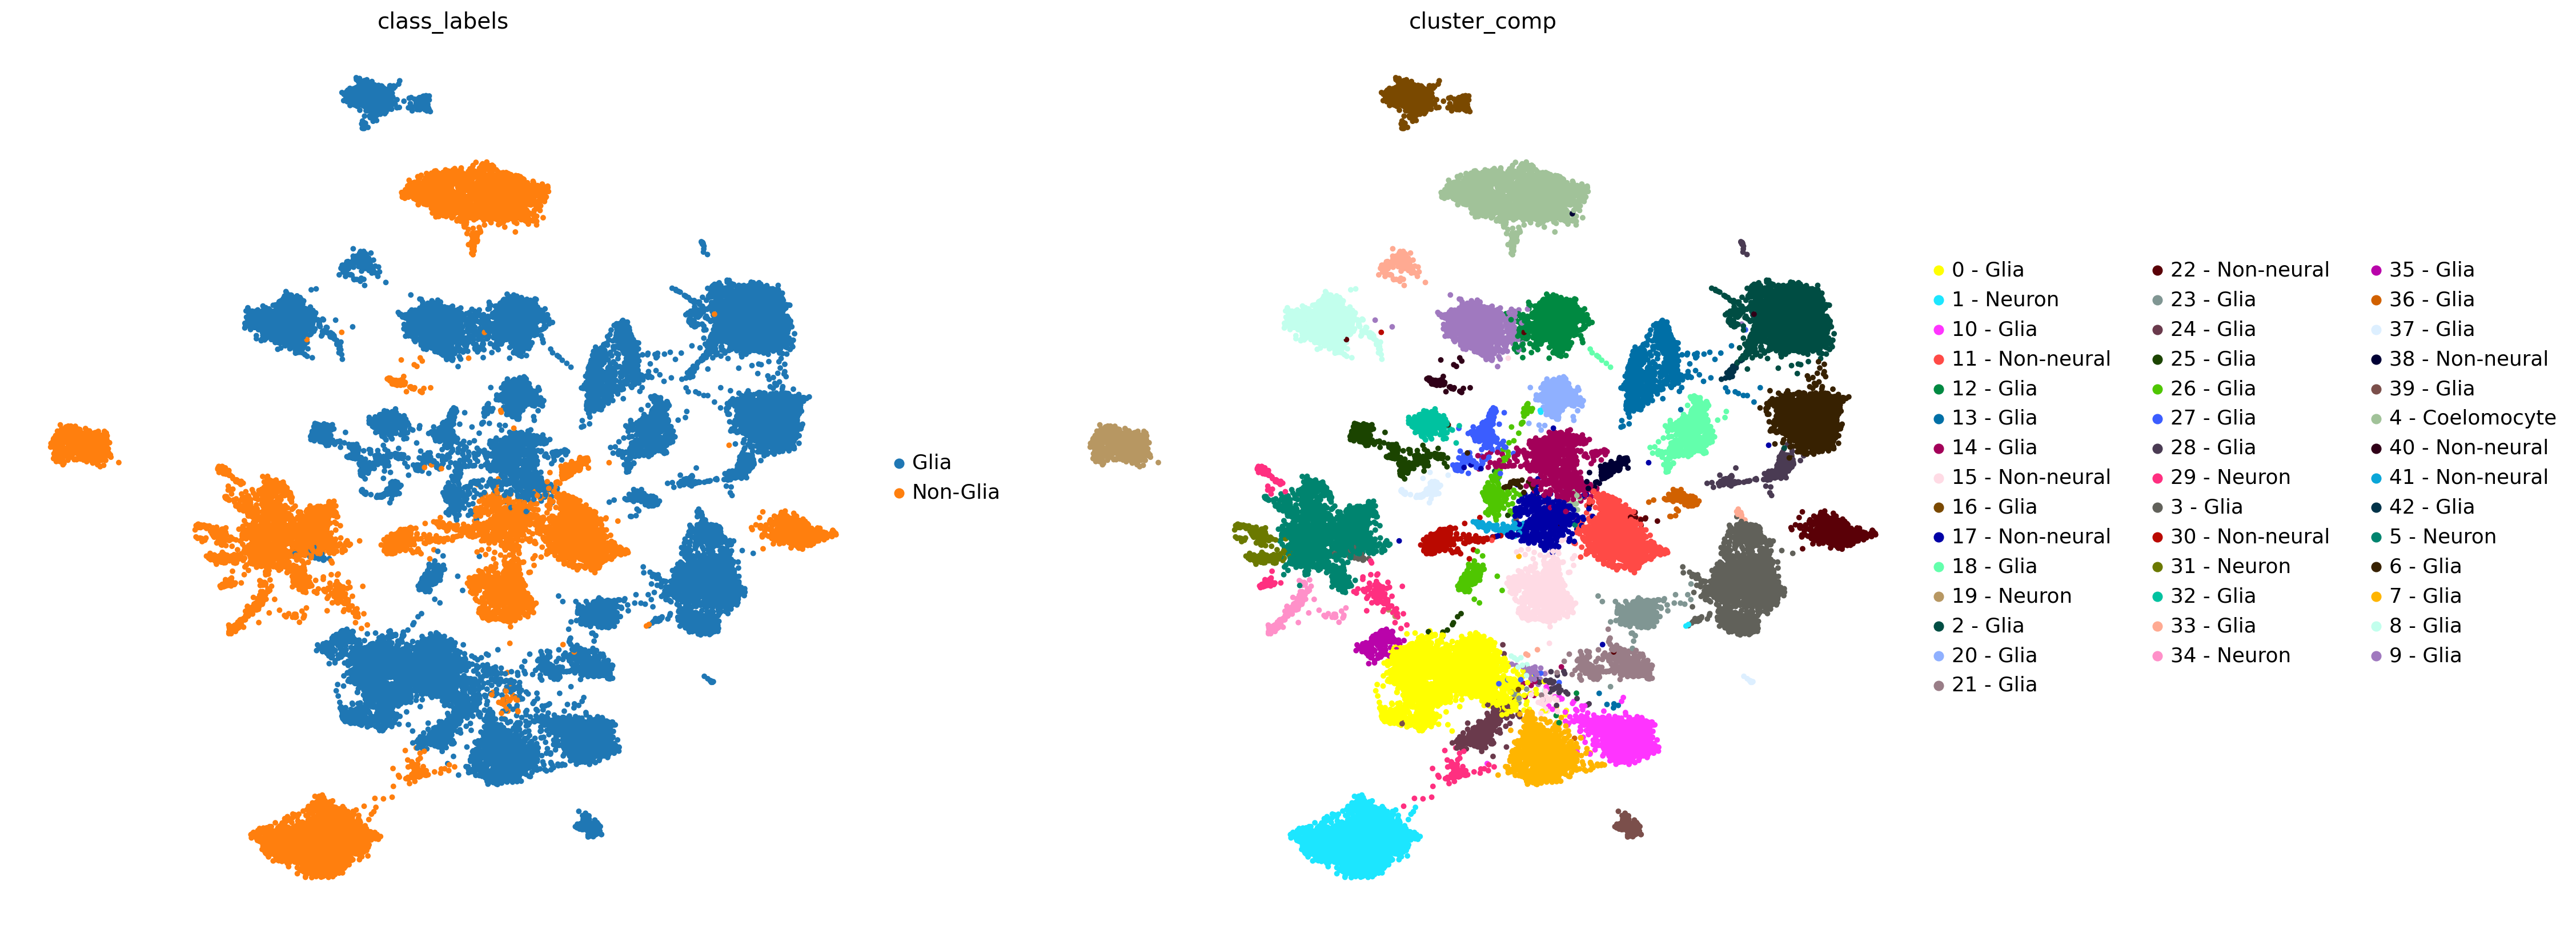

In [6]:
with matplotlib.pyplot.rc_context({'figure.figsize':(10,10)}):
    sc.pl.umap(
        adata,
        color=[CLASS_LABELS, CLUSTER_LABELS],
        frameon=False,
        size=50
    )

As described in our manuscript and glia-only subclustering analyses and validations, some clusters possess transcriptomic profiles similar to glia but are non-glia (these are: `'Unvalidated', 'Posterior hyp', 'Seam cells', 'PChL/R'` celltypes). We identify these cells and exclude them from our analysis. We perform this exclusion at the cluster level by identifying clusters that have high proportion of these cells in the complete dataset.

In [7]:
# exclude cells not used in the sheat/socket marker analyses
adata_glia = sc.read('data/GliaOnly.h5ad')

# exclude -- 'Unvalidated', 'skin-like glia', PChL/R'
# adata_glia_idx = adata

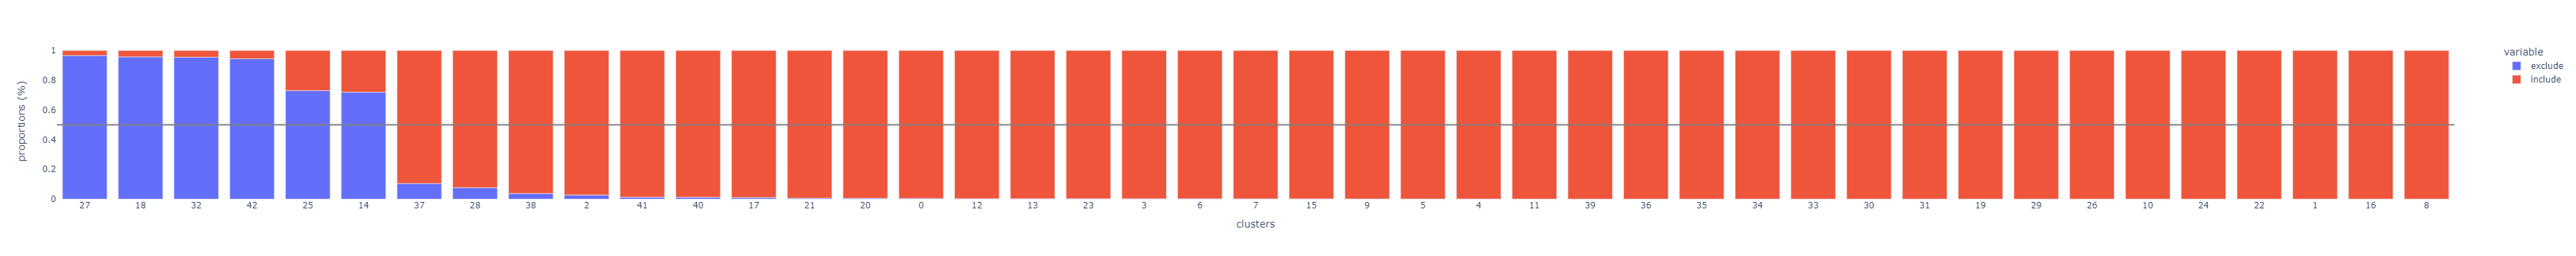

In [12]:
exclude_idx = adata_glia.obs.loc[adata_glia.obs['Celltype'].isin(['Unvalidated', 'Posterior hyp', 'Seam cells', 'PChL/R'])].index

# for each of the clusters quantify how many of each of those cells are in the clusters
adata.obs.loc[:,'inclusion_label'] = pd.Series(adata.obs_names.isin(exclude_idx)).map(lambda x: 'exclude' if x else 'include').values

# get the counts
inclusion_proportions =adata.obs.loc[:,['leiden_postBC','inclusion_label']] \
    .groupby(['leiden_postBC','inclusion_label']) \
    .agg({'leiden_postBC':'count'}) \
    .unstack() \
    .reset_index(drop=True) \
    .droplevel(level=0, axis=1) 

# process and compute the proportions of include/exclude cells per cluster
inclusion_proportions.columns.name = 'clusters'
inclusion_proportions = inclusion_proportions.divide(inclusion_proportions.sum(axis=1), axis=0)
inclusion_proportions.sort_values(by='exclude', inplace=True, ascending=False)
inclusion_proportions.loc[:,'clusters'] = inclusion_proportions.index
inclusion_proportions.clusters = inclusion_proportions.clusters.astype(str)

# plot as a stacked barchart 
fig_proportions = px.bar(data_frame=inclusion_proportions, x='clusters', y=['exclude','include'])
fig_proportions.update_layout(
    plot_bgcolor="rgba(0,0,0,0)",
    hovermode='x unified',
    yaxis=dict(title='proportions (%)')
)
fig_proportions.add_hline(y=0.50, line_color='gray')

Above, we identify cluster `27, 18, 32, 42, 25, 14` and exclude them from the downstream analyses

In [18]:
# exclude the clusters if it composes of more than > 50% exclude -- exclude via leiden_postBC
exclude_clusters = inclusion_proportions.index[inclusion_proportions.exclude > 0.5].astype(str).tolist()

# rename these clusters as glia-like non-neural
map_new_labels = {
    '27 - Glia': '27 - Glia-like non-neural',
    '18 - Glia': '18 - Glia-like non-neural',
    '32 - Glia': '32 - Glia-like non-neural',
    '42 - Glia': '42 - Glia-like non-neural',
    '25 - Glia': '25 - Glia-like non-neural',
    '14 - Glia': '14 - Glia-like non-neural'
}
adata.obs.loc[:,CLUSTER_LABELS] = adata.obs.loc[:,CLUSTER_LABELS].replace(map_new_labels)

# get the clusters to be excluded
EXCLUDE_CLUSTERS = adata.obs.loc[adata.obs['leiden_postBC'].isin(exclude_clusters), CLUSTER_LABELS].unique().tolist()

The excluded clusters are highlighted below and highlight them as glia-like non-neural clusters

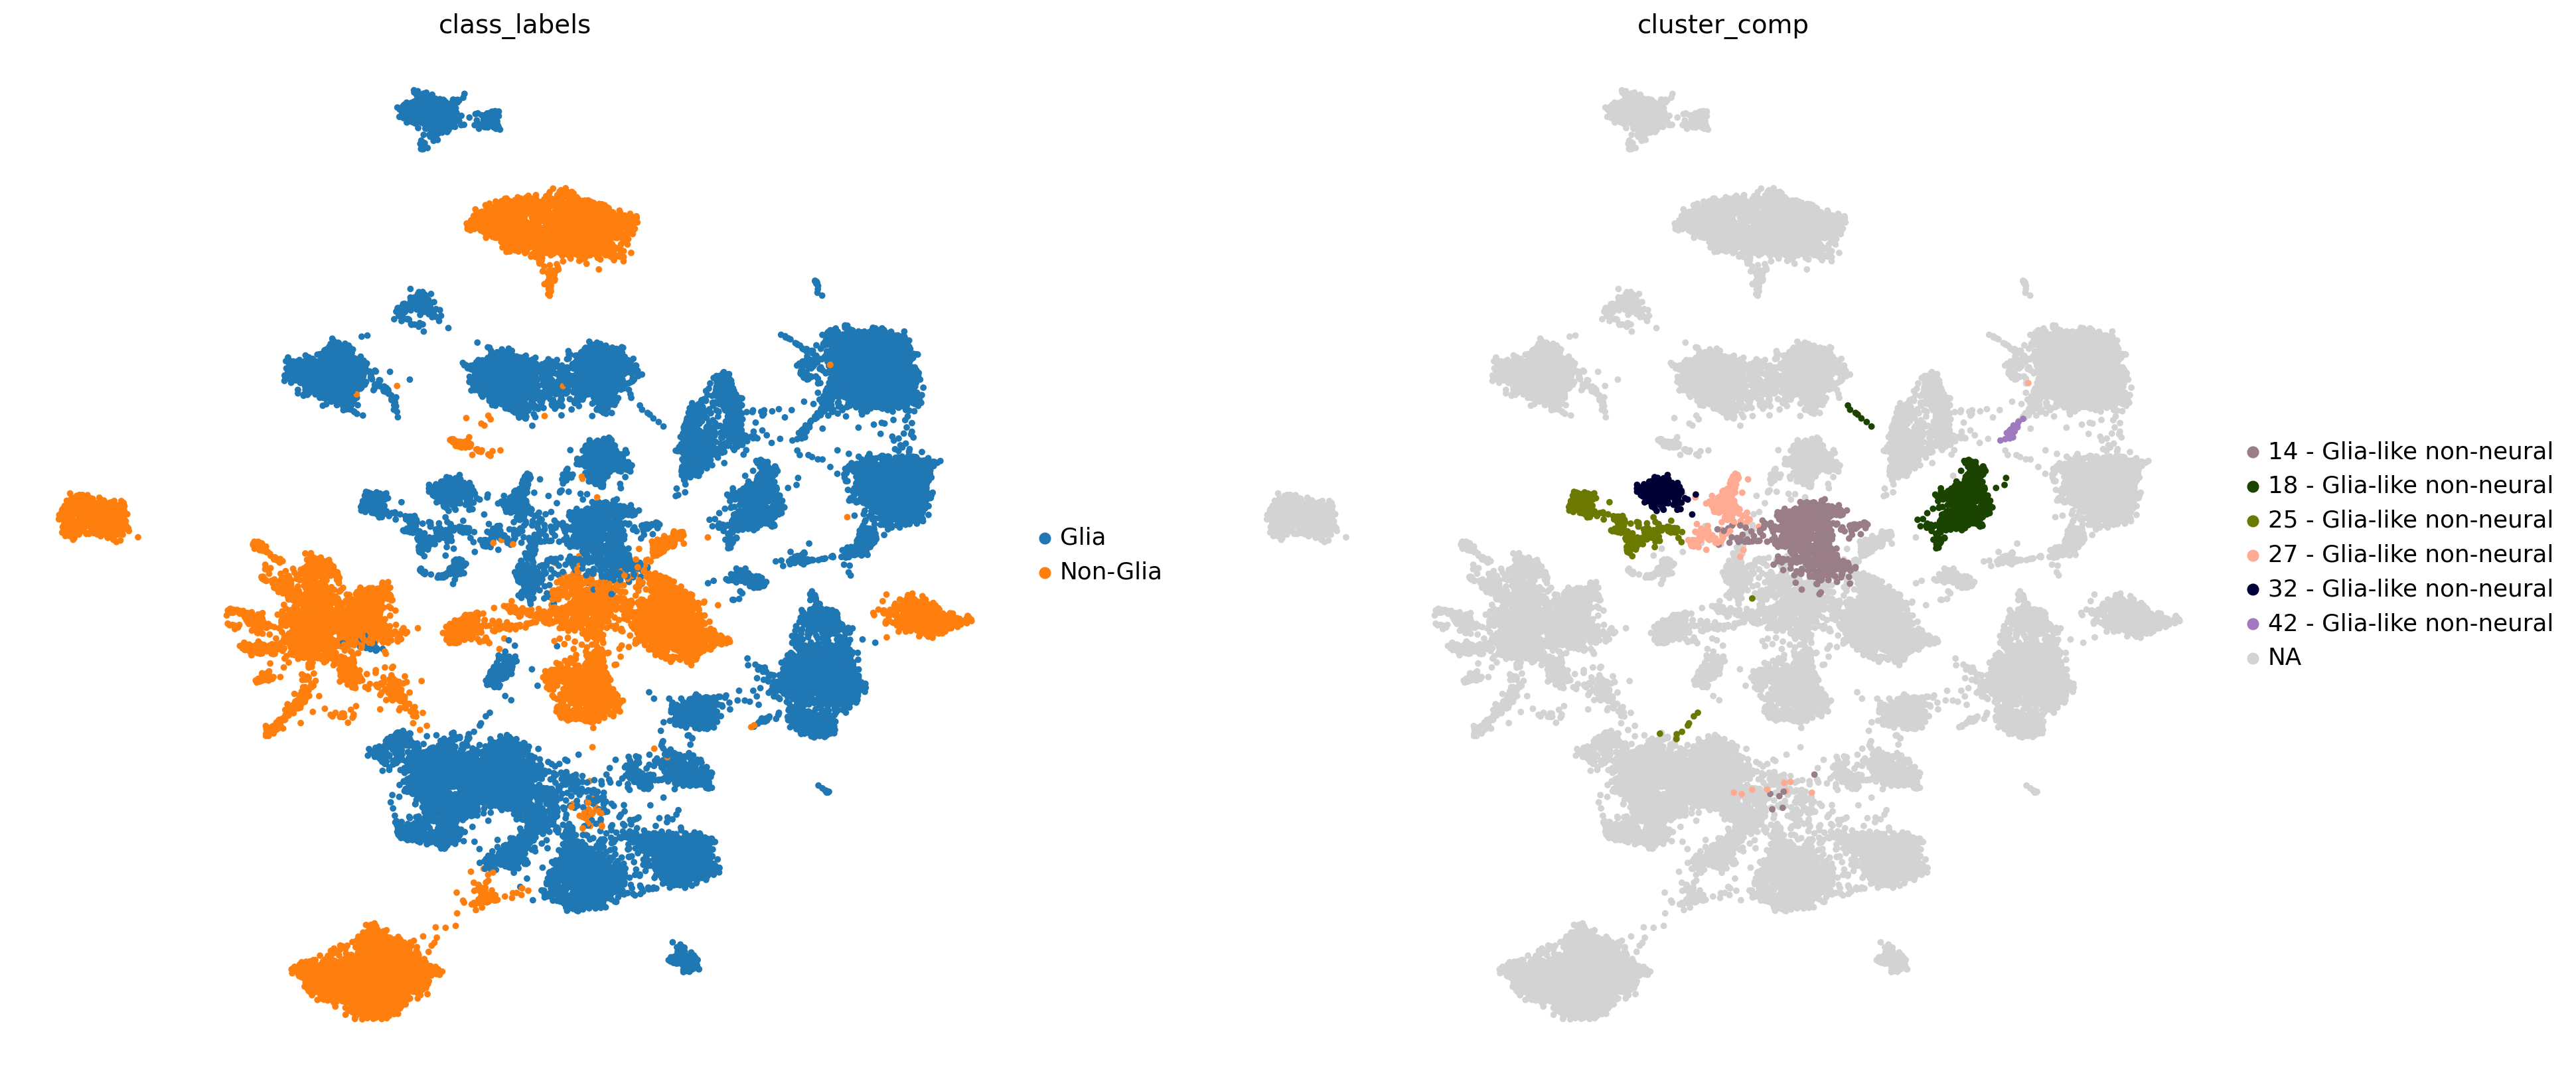

In [19]:
# inspect the current data -- highlighting which clusters are to be excluded from the analysis
with matplotlib.pyplot.rc_context({'figure.figsize':(10,10)}):
    sc.pl.umap(
        adata,
        color=[CLASS_LABELS, CLUSTER_LABELS],
        groups = ['Glia','Non-Glia'] + EXCLUDE_CLUSTERS,
        frameon=False,
        size=50
    )

# Filter Features/Genes

We first perform pre-filtering of the genes. For our feature ranking, we constrain our selection of genes to only identified highly variable genes which is is denoted by `anndata.var[USE_GENES]`. 

We filter genes by calculating the fraction of cells expressing a gene within each cluster in `anndata.obs[CLUSTER_LABELS]`.

For this analysis, genes are kept if they are expressed (have non-zero counts) in greater than <b><i>40% (0.40) of cells in a specific cluster AND if this is the case for more than one cluster or more</i></b>. 

This filtering step can be done by calling `filter_features()`. This function modifies the `anndata` in place and the following are added:
1. `anndata.obs['exclude_cells']` : a column in `anndata.obs` attribute containing boolean values indicating whether a cell is to be included/excluded
2. `anndata.var['identified_genes']` : a columns in `anndata.var` attribute containing boolean values indicating which genes are to be the focus of the analysis

In [20]:
# other arguments -- we've identified nlp-77 before hand to be expressed broadly and exclude this gene from the rest of the anlysis
IGNORE_FEATURES = ['nlp-77'] # features we ignored as described in the manuscript

In [21]:
filter_features(adata, use_feature_set=USE_GENES, 
                cluster_label=CLUSTER_LABELS, ignore_clusters=EXCLUDE_CLUSTERS, frac_expr_thresh=0.40)

Identifying genes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3355/3355 [03:43<00:00, 14.99it/s]


Number of genes identified: 330


# Create Data

For this analysis, we perform out feature selection in Hermaphrodite samples only as described in our manuscript

In [22]:
# herm only data -- will be used for this analysis
adata_herm = adata[
    (adata.obs['sex'] == 'Hermaphrodite') & 
    (adata.obs['sex_specificity_postBC'].isin(['Both','Herm'])),:].copy()
adata_herm

AnnData object with n_obs × n_vars = 16655 × 12376
    obs: 'leiden_postBC', 'leiden_preBC', 'sex', 'Compartments_postBC', 'Celltype', 'cluster_sex_label_postBC', 'Compartments_preBC', 'samples', 'sex_specificity_postBC', 'sex_specificity_preBC', 'Cluster_Celltype', 'class_labels', 'cluster_comp_sexes', 'cluster_comp', 'inclusion_label', 'exclude_cells'
    var: 'previous_highly_variable', 'highly_variable', 'identified_genes'
    uns: 'Compartments_colors', 'Compartments_postBC_colors', 'Compartments_preBC_colors', 'DMEigenValues_postBC', 'DMEigenValues_preBC', 'class_labels_colors', 'cluster_sex_label_colors', 'dendrogram_Cluster_Celltype', 'gene_validations', 'leiden_postBC_colors', 'leiden_preBC_colors', 'samples_colors', 'sex_colors', 'sex_frac_postBC', 'sex_frac_preBC', 'sex_specificity_colors', 'sex_specificity_postBC_colors', 'sex_specificity_preBC_colors', 'cluster_comp_colors'
    obsm: 'DM_EigenVectors_postBC', 'DM_EigenVectors_preBC', 'X_pca', 'X_pca_harmony', 'X_umap', 'X_

# Create Training, Validation & Test Set

We create training, validation and test datasets as follows

In [23]:
split_data(ad_data=adata_herm, cluster_label=CLUSTER_LABELS) 

Splitting Data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 796.05it/s]


We can view the training/validation/test splits below by plotting the umap and coloring it by `data_splits` which has been added:

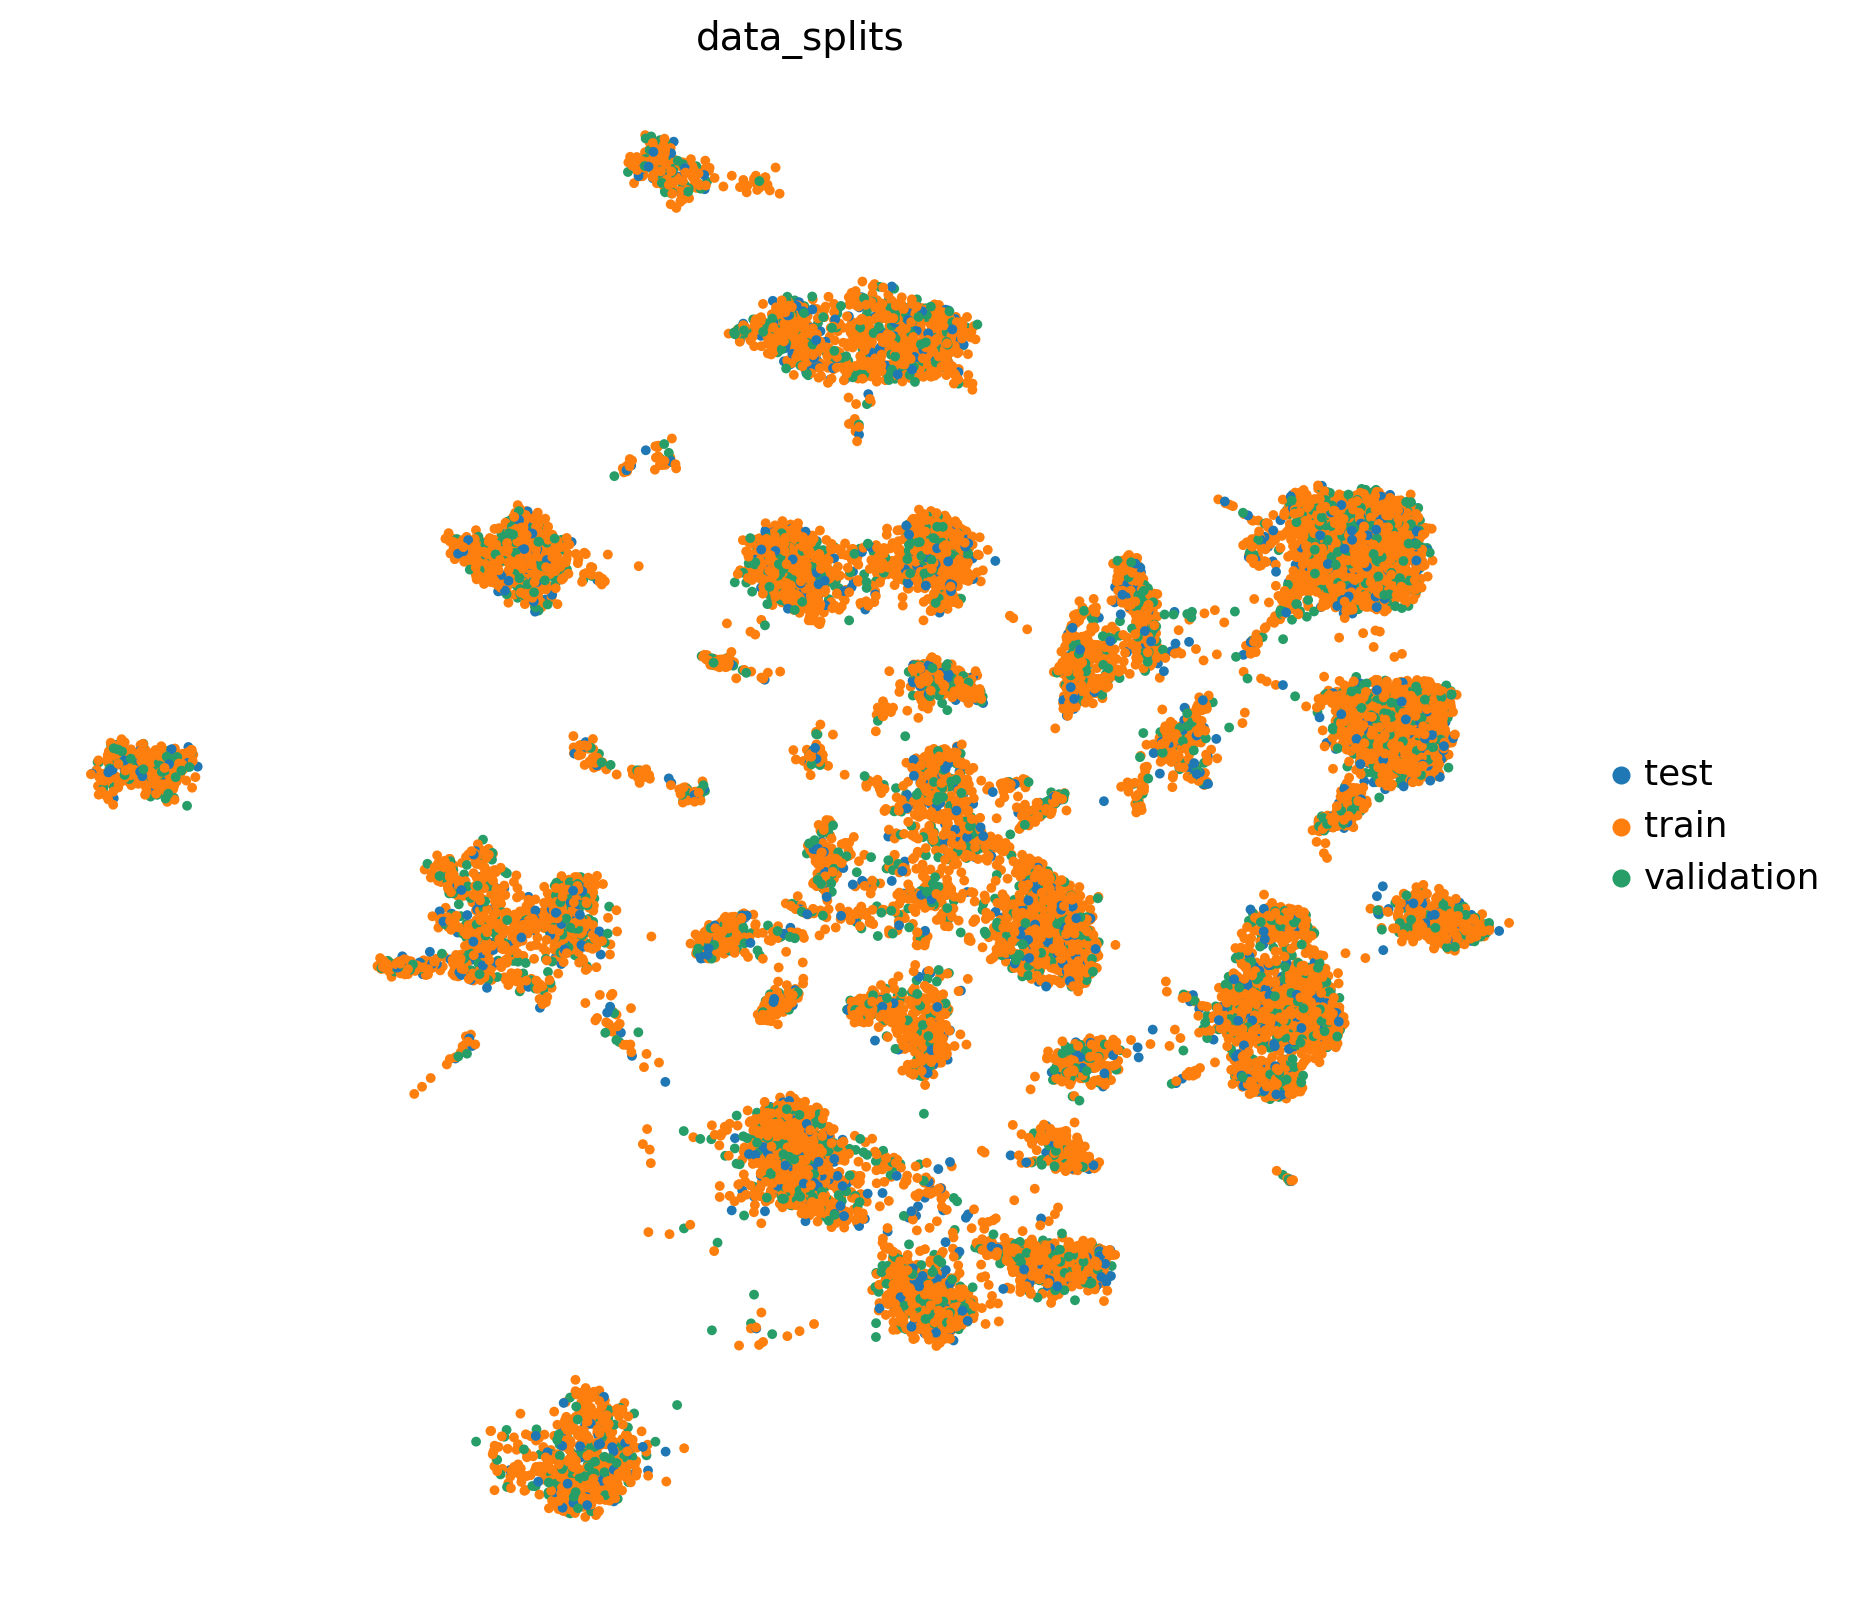

In [24]:
# probably visualize the umap with the labeled test-validation-test splits
with matplotlib.pyplot.rc_context({'figure.figsize':(10,10)}):
    sc.pl.umap(
        adata_herm,
        color=['data_splits'],
        frameon=False,
        size=50
    )

# Model Training & Selection

As described in our manuscript, we learn a mapping between the feature matrix and the target vector by leveraging a binary classifier using the scikit-learn package and create a `Logistic Regression` model to dishtinguish between the two classes in `anndata.obs[CLASS_LABELS]`.

A feature matrix and target vector pair was constructed for each of the labels in `anndata.obs['data_splits']` where the entry of the feature matrix is the imputed gene expression avalues of the genes identified in `anndata.var['identified_genes']`. 

Multiple models are trained using `L1/lasso-regularization` under different regularization conditions: `[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]` 

This can be done by calling `train_model()` which returns a selected regularized model based on highest mean-accuracy metrics on the validation dataset and also adds mean-accuracy scores for each of the trained models in `anndata.uns['model_selection_metrics']`.

In [25]:
# return_all params -- will return things other than the model such as the score
model, trained_models, scores = train_model(ad_data=adata_herm, class_label=CLASS_LABELS, 
                               use_layer=USE_LAYER, save_path=SAVE_PATH, return_all=True)

Training Model(s): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.04it/s]

best_model: model_5.0
54 out of 330 features remain in the selected model.
Directory '2023-09-18-PanGlia_Analysis' already exists -- saving results to 2023-09-18-PanGlia_Analysis.


In [26]:
# checkout the scores for each of the models
scores

train_score  validation_score  test_score
model_0.001     0.827504          0.822004    0.822571
model_0.005     0.966523          0.966713    0.958621
model_0.01      0.991631          0.991240    0.988715
model_0.05      0.993833          0.994744    0.989342
model_0.1       0.994274          0.994744    0.989969
model_0.5       0.996036          0.996847    0.994357
model_1.0       0.996388          0.997197    0.994357
model_5.0       0.997886          0.997547    0.994984

# Feature Ranking/Selection

To select markers, we specify the target class we want to identify for (`Glia` or `Non-glia` which are the two classes available in `anndata.obs[CLASS_LABELS]`). Additionally, as described in the manuscript, we select a default of `n_features=10 genes`.

We identify markers as described in the manuscript which can be done by calling `rank_genes()`. This function modifies the anndata in place and adds the results on to the `anndata` object within `anndata.uns['<target_class>_marker_results']`. Which contains dictionaries of the results.

Particularly `anndata.uns['<target_class>_marker_results']['top_<n_features>']` contains the top `n_features` selected genes

## Marker Identification --  Glia

In [27]:
rank_genes(ad_data=adata_herm, model=model, target_class='Glia', 
                 class_labels=CLASS_LABELS, cluster_labels=CLUSTER_LABELS, use_layer=USE_LAYER, n_features=10, ignore_features=IGNORE_FEATURES)

Number of features to select: 10 from the available 54 features in the current model. ignoring: ['nlp-77']


# Visualize Results

The markers can be accessed as follows in the current `anndata` <b>adata_herm</b> object

### Gene Expression -- Whole Data

We can visualize the results as follows using the `scanpy` module on both the Hermaphrodite and Male data

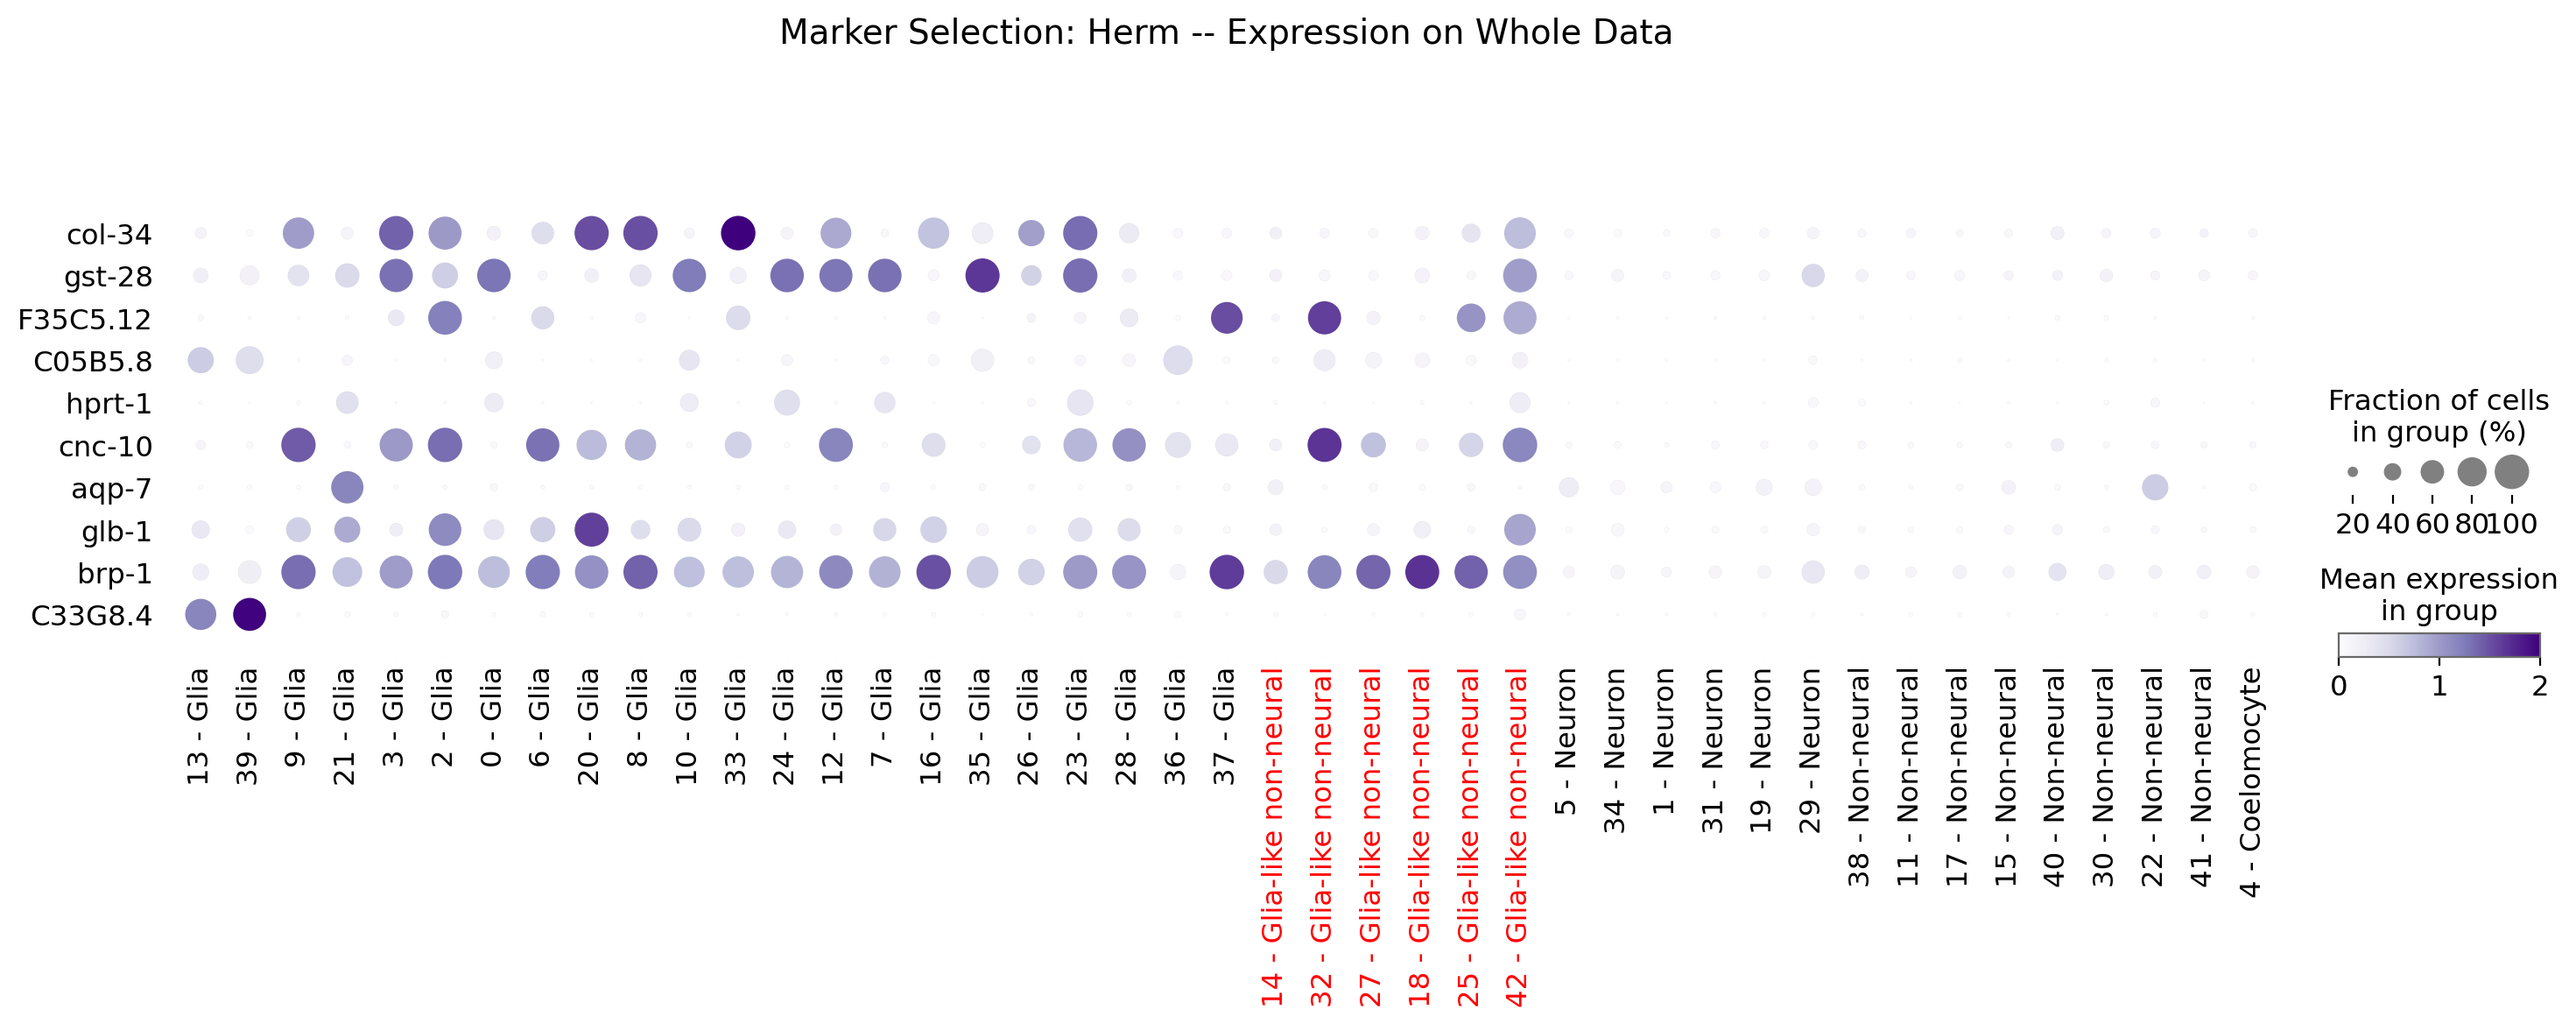

In [35]:
# identified genes
markers = adata_herm.uns['Glia_marker_results']['top_10']

# ordering of the compartments
glia_mask = pd.Series(adata.obs['cluster_comp'].unique()).str.endswith('Glia')
glia_cluster = pd.Series(adata.obs['cluster_comp'].unique())[glia_mask].values.tolist()

glia_like_mask = pd.Series(adata.obs['cluster_comp'].unique()).str.contains('Glia-like')
glia_like_cluster = pd.Series(adata.obs['cluster_comp'].unique())[glia_like_mask].values.tolist()

neuron_mask = pd.Series(adata.obs['cluster_comp'].unique()).str.contains('Neuron')
neuron_cluster = pd.Series(adata.obs['cluster_comp'].unique())[neuron_mask].values.tolist()

coelomocyte_mask = pd.Series(adata.obs['cluster_comp'].unique()).str.contains('Coelomocyte')
coelomocyte_cluster = pd.Series(adata.obs['cluster_comp'].unique())[coelomocyte_mask].values.tolist()

anatomical_mask = pd.Series(adata.obs['cluster_comp'].unique()).str.contains('Non-neural')
anatomical_cluster = pd.Series(adata.obs['cluster_comp'].unique())[anatomical_mask].values.tolist()

category_order = glia_cluster + glia_like_cluster + neuron_cluster + anatomical_cluster + coelomocyte_cluster

# visualize the markers using scanpy -- var_names takes in the 'markers' dictionary we've defined containing the genes we've identified
with matplotlib.pyplot.rc_context({'axes.edgecolor':'dimgray', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    all_data = sc.pl.dotplot(adata, var_names=markers, groupby='cluster_comp', use_raw=False, categories_order=category_order,\
                             dendrogram=False, swap_axes=True, title='Marker Selection: Herm -- Expression on Whole Data', vmax=2, return_fig=True, cmap='Purples')
    all_data.dot_edge_lw = 0.01
    
    # fix the aesthetics
    all_data.get_axes()['mainplot_ax'].axes.tick_params(axis='both', which='both',length=0.01)
    
    # color the texts based on whether the cluster belongs to Sheath or Socket Class
    xticks = all_data.get_axes()['mainplot_ax'].axes.get_xticklabels()
    for tick in xticks:
        if tick.get_text() in EXCLUDE_CLUSTERS:
            tick.set_color('red')
        else:
            tick.set_color('black')
    plt.savefig('fig_outputs/new_pan_glia_signatures.png', bbox_inches='tight')    

# Summary Metrics of Marker Selection Process

Using the `view_ProbEst_Summary()` function we can view the effecs of gradual selection of genes/features on the model's confidence in identifying a particular target class. The plot generated below are the probability estimates per cluster for a given class with a given set of selected features/genes for that class using `1` to `n_features`.

In [37]:
# socket markers are stored in the herm anndata.uns attribute
glia_combinations = adata_herm.uns['Glia_marker_results']['all_combinations']

### Male Samples

Create the male data

In [39]:
# hermaphrodite only data -- for evaluating features selected
adata_male = adata[
    (adata.obs['sex'] == 'Male') & 
    (adata.obs['sex_specificity_postBC'].isin(['Both','Male'])),:].copy()

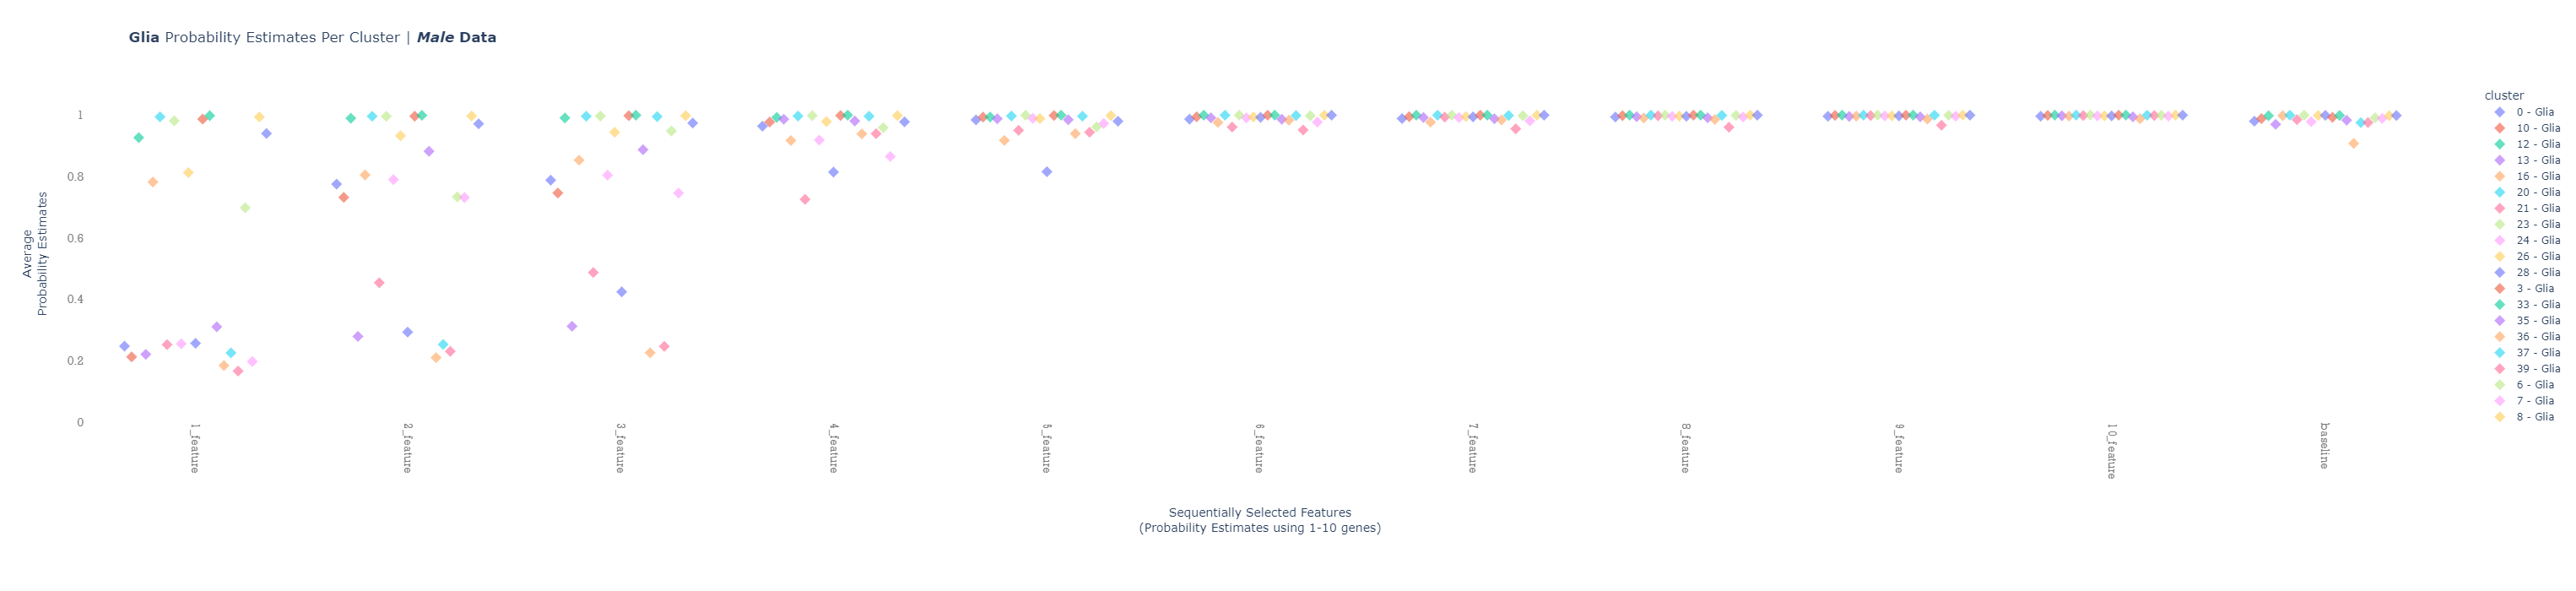

In [41]:
# male glia
view_ProbEst_Summary(
    adata_male, 
    model=model,
    target_class='Glia',
    feature_combos=glia_combinations,
    class_labels=CLASS_LABELS,
    cluster_labels=CLUSTER_LABELS,
    use_layer=USE_LAYER
)

### Hermaphrodite Samples

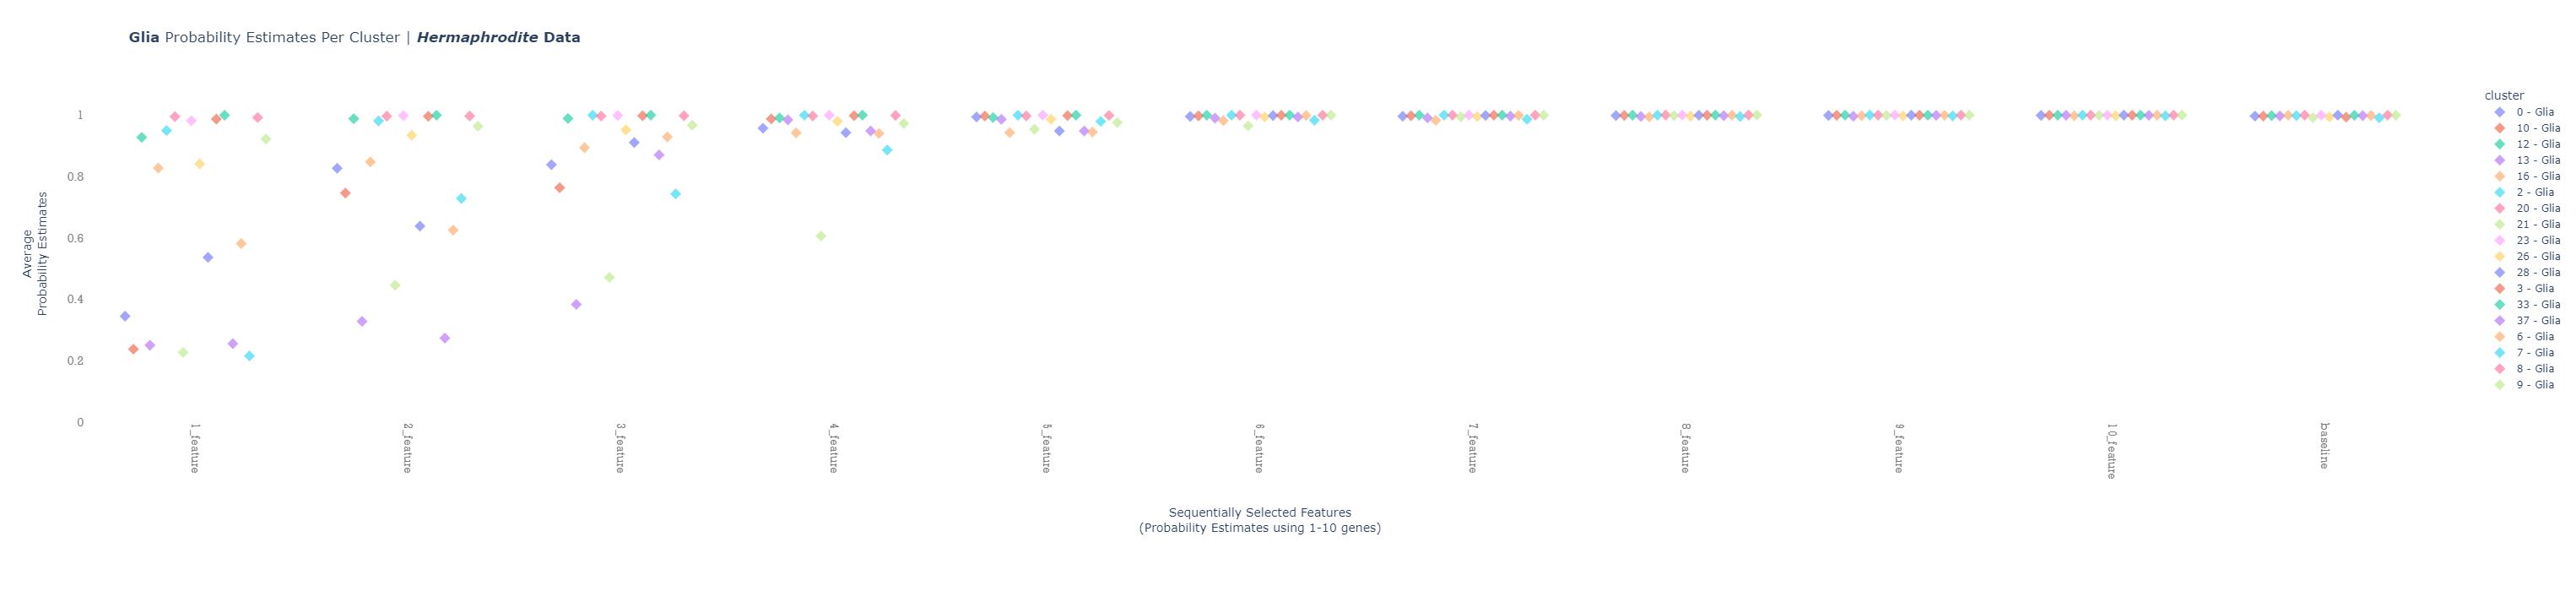

In [42]:
# herm socket
view_ProbEst_Summary(
    adata_herm, 
    model=model,
    target_class='Glia',
    feature_combos=glia_combinations,
    class_labels=CLASS_LABELS,
    cluster_labels=CLUSTER_LABELS,
    use_layer=USE_LAYER
)

# Binary Classification Performance

Using `view_AUROC_Summary()` we can evaluate and view the performance of the classifier using the set of identified genes for each of the target class.

In [47]:
# using the top 10 identified glial genes -- these will be names as the subset of of features learned by the model
markers = adata_herm.uns['Glia_marker_results']['top_10']
markers

['col-34',
 'gst-28',
 'F35C5.12',
 'C05B5.8',
 'hprt-1',
 'cnc-10',
 'aqp-7',
 'glb-1',
 'brp-1',
 'C33G8.4']

### Male Samples

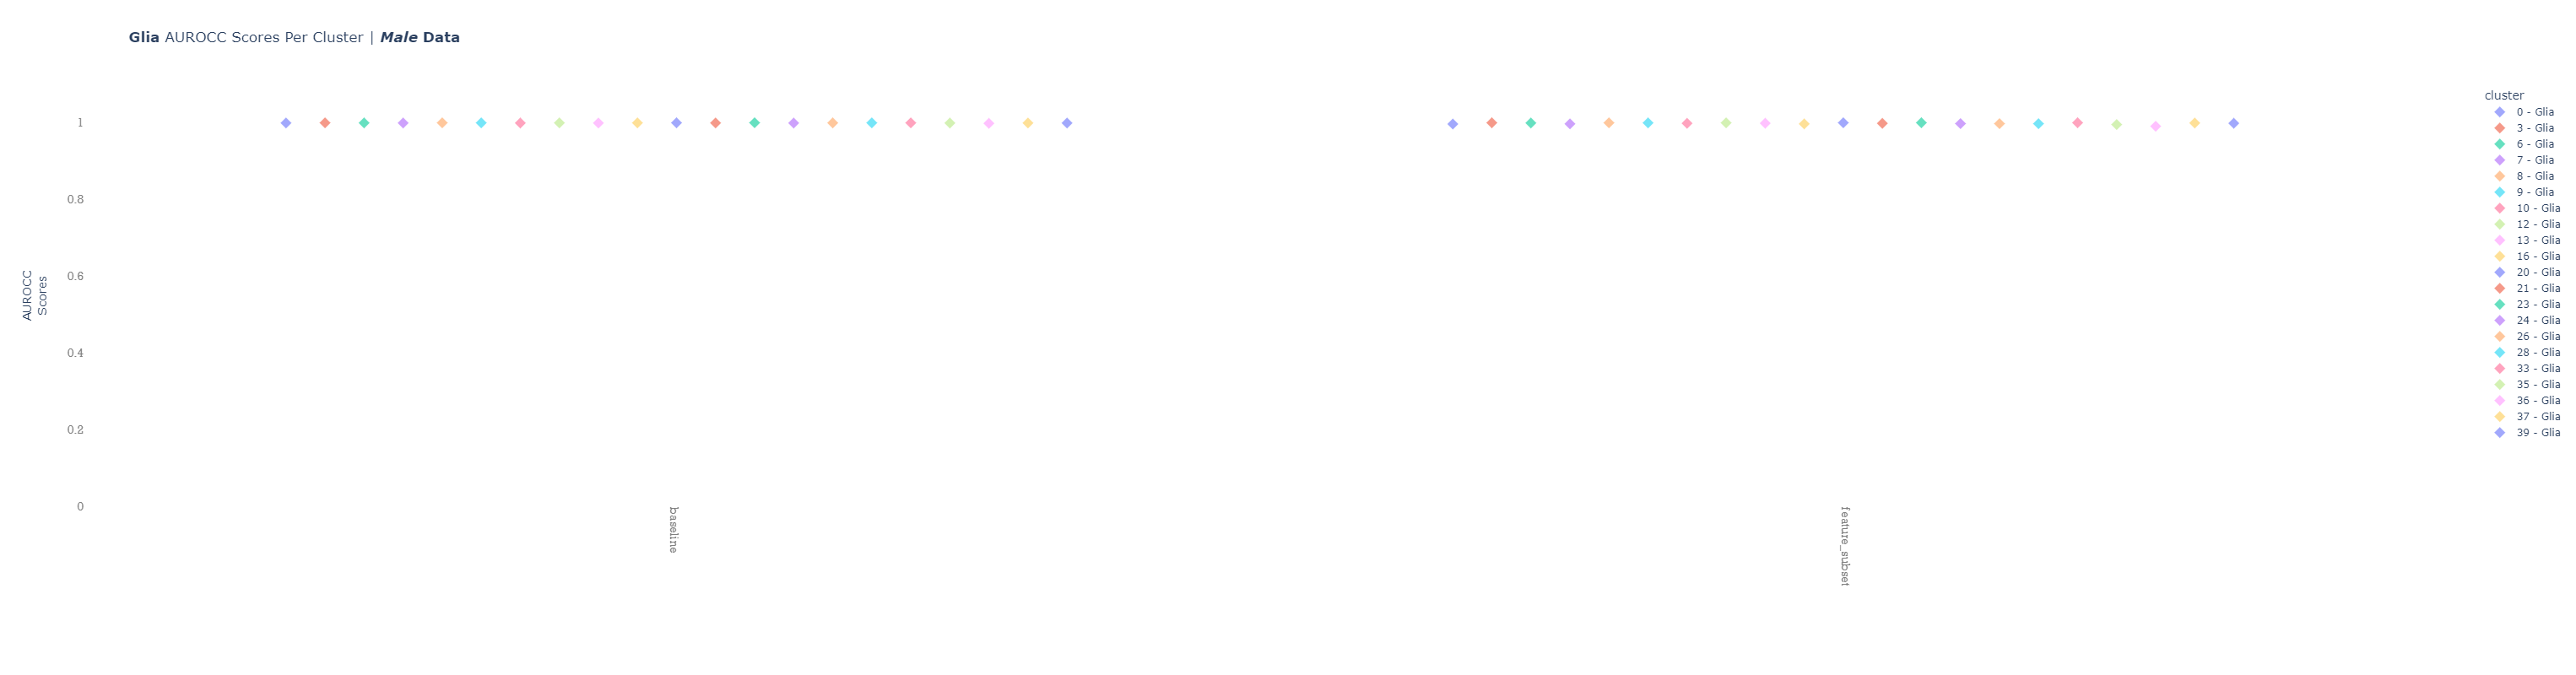

In [48]:
# males
view_AUROCC_Summary(adata_male, model=model, target_class='Glia', class_labels=CLASS_LABELS, 
                   cluster_labels=CLUSTER_LABELS, use_layer=USE_LAYER, target_features=markers)

### Hermaphrodite Samples

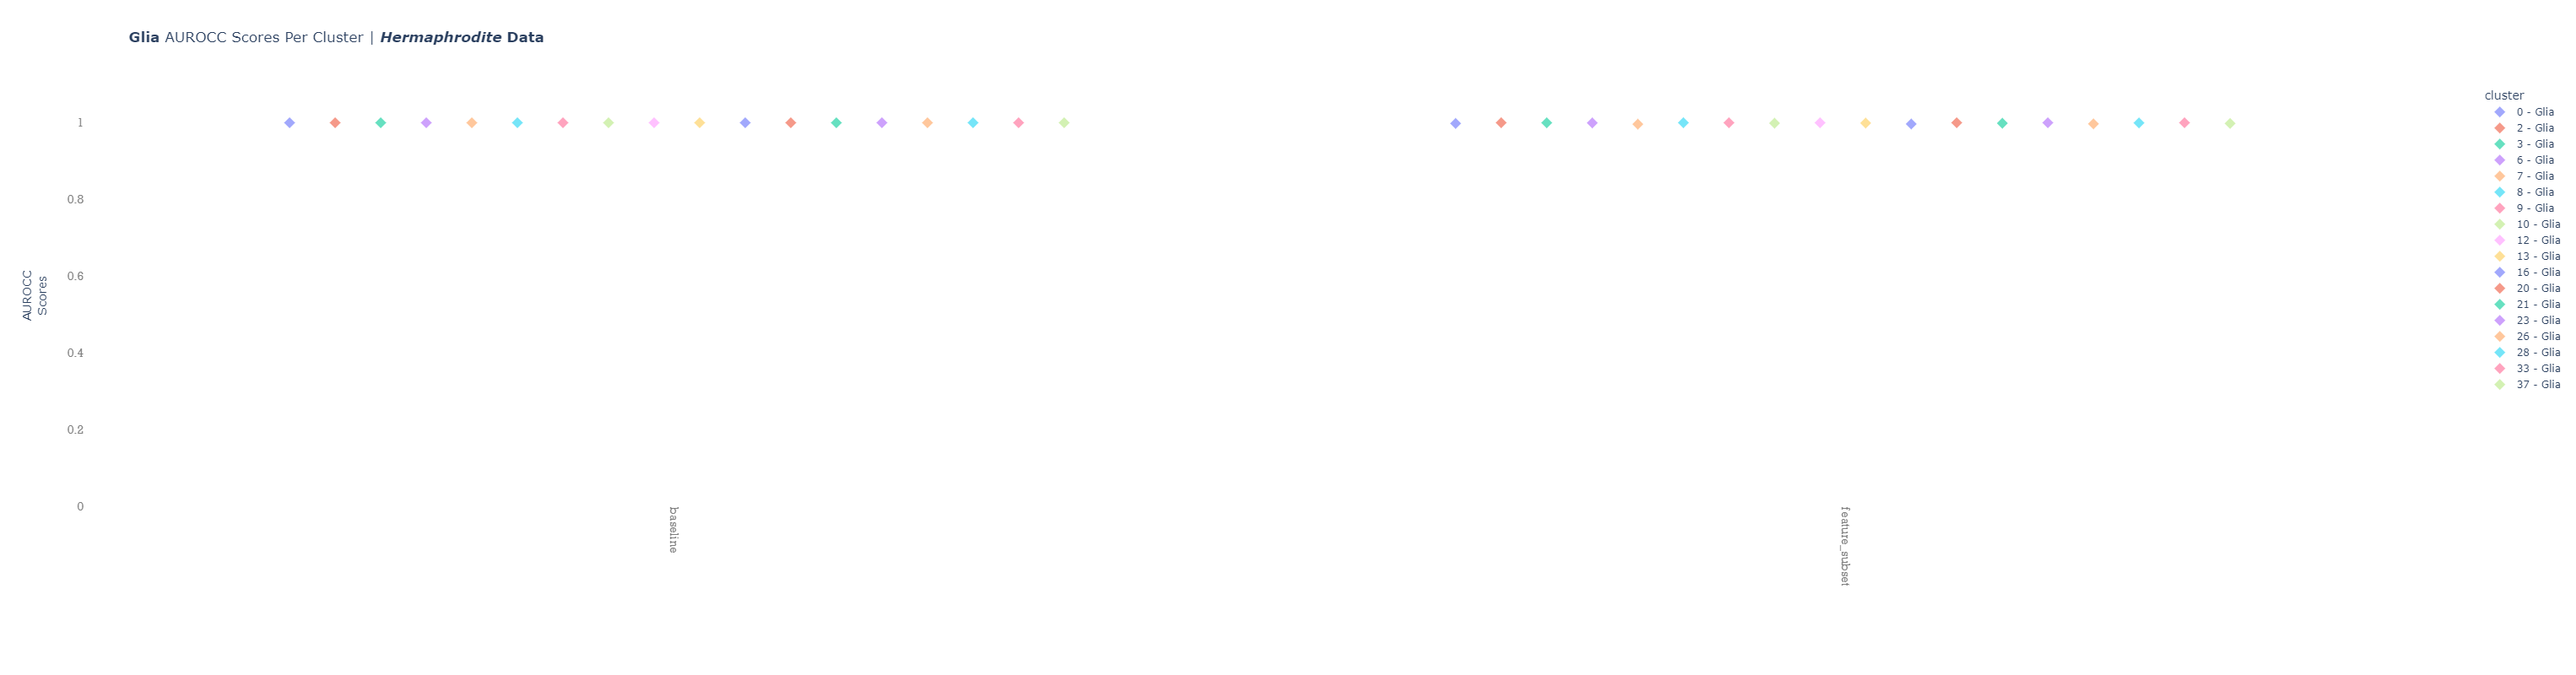

In [49]:
# hermaphrodites
view_AUROCC_Summary(adata_herm, model=model, target_class='Glia', class_labels=CLASS_LABELS, 
                   cluster_labels=CLUSTER_LABELS, use_layer=USE_LAYER, target_features=markers)

### Save Anndatas

In [50]:
# saves the male data -- used in training 
adata_male.write(f'{SAVE_PATH}/adata_male.h5ad')

# saves the hermaphrodite data
adata_herm.write(f'{SAVE_PATH}/adata_herm.h5ad')

# saves the original data with modiefied .var, .obs, .uns attributes
adata.write(f'{SAVE_PATH}/adata.h5ad')